# Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**


In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import time

iris = load_iris()

x = iris.data
y = iris.target

In [8]:
def entropy_func(class_count: int, num_samples: int) -> float:
    probability = class_count / num_samples
    return -probability * np.log2(probability)


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self) -> int:
        return self.group_classes.size

    def group_entropy(self) -> float:
        _, class_counts = np.unique(self.group_classes, return_counts=True)
        num_samples = len(self.group_classes)
        return sum(entropy_func(count, num_samples) for count in class_counts)


class Node:
    def __init__(self, split_feature=None, split_val=None, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data: np.ndarray) -> int:
        if self.val is not None:
            return self.val
        elif data[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)


class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a: Group, group_b: Group) -> float:
        total_samples = len(group_a) + len(group_b)
        return (len(group_a) / total_samples) * group_a.group_entropy() + (len(group_b) / total_samples) * group_b.group_entropy()

    def get_information_gain(self, parent_group: Group, child_group_a: Group, child_group_b: Group) -> float:
        return parent_group.group_entropy() - self.get_split_entropy(child_group_a, child_group_b)

    def get_best_feature_split(self, feature_values: np.ndarray, classes: np.ndarray) -> Tuple[int, float]:
        parent_group = Group(classes)
        best_split_value = None
        best_gain = -1
        for split_feature in np.unique(feature_values):
            a_indices = feature_values <= split_feature
            b_indices = feature_values > split_feature
            if not np.any(a_indices) or not np.any(b_indices):
                continue

            group_a = Group(classes[a_indices])
            group_b = Group(classes[b_indices])
            gain = self.get_information_gain(parent_group, group_a, group_b)
            if gain > best_gain:
                best_split_value = split_feature
                best_gain = gain

        return best_split_value, best_gain

    def get_best_split(self, data: np.ndarray, classes: np.ndarray) -> Tuple[int, int, float]:
        best_split_value = None
        best_split_feature = None
        best_gain = -1

        for feature_index in range(data.shape[1]):
            feature_values = data[:, feature_index]
            split_value, gain = self.get_best_feature_split(feature_values, classes)
            if gain > best_gain:
                best_split_value = split_value
                best_split_feature = feature_index
                best_gain = gain

        return best_split_feature, best_split_value, best_gain

    def build_tree(self, data: np.ndarray, classes: np.ndarray, depth=0) -> Node:
        if depth >= self.max_depth or len(np.unique(classes)) == 1:
            majority_class = Counter(classes).most_common(1)[0][0]
            return Node(val=majority_class)

        split_feature, split_value, best_gain = self.get_best_split(data, classes)
        if split_feature is None:
            majority_class = Counter(classes).most_common(1)[0][0]
            return Node(val=majority_class)

        a_indices = data[:, split_feature] <= split_value
        b_indices = data[:, split_feature] > split_value
        child_node_a = self.build_tree(data[a_indices], classes[a_indices], depth + 1)
        child_node_b = self.build_tree(data[b_indices], classes[b_indices], depth + 1)

        return Node(split_feature, split_value, depth, child_node_a, child_node_b)

    def fit(self, data: np.ndarray, classes: np.ndarray):
        self.tree = self.build_tree(data, classes)

    def predict(self, data: np.ndarray) -> int:
        if self.tree is not None:
            return self.tree.predict(data)

## Testowanie solvera dla przypadku podanego w treści zadania

In [9]:
decision_classifier = DecisionTreeClassifier(3)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)
decision_classifier.fit(x_train, y_train)

samples_number = len(y_test)
correctly_predicted = 0
for sample, gt in zip(x_test, y_test):
    prediction = decision_classifier.predict(sample)
    if prediction == gt:
        correctly_predicted += 1
        print(f"Features: {sample},\t Actual: {gt},\t Predicted: {prediction}")
    else:
        print(f"Features: {sample},\t Actual: {gt},\t Predicted: {prediction}\t Wrong!")

print(f"Accuracy: {(correctly_predicted / samples_number) * 100}%")

Features: [6.3 2.5 4.9 1.5],	 Actual: 1,	 Predicted: 2	 Wrong!
Features: [6.8 3.  5.5 2.1],	 Actual: 2,	 Predicted: 2
Features: [6.4 2.8 5.6 2.2],	 Actual: 2,	 Predicted: 2
Features: [5.6 3.  4.1 1.3],	 Actual: 1,	 Predicted: 1
Features: [4.9 3.6 1.4 0.1],	 Actual: 0,	 Predicted: 0
Features: [6.  3.  4.8 1.8],	 Actual: 2,	 Predicted: 2
Features: [6.3 2.3 4.4 1.3],	 Actual: 1,	 Predicted: 1
Features: [4.4 3.2 1.3 0.2],	 Actual: 0,	 Predicted: 0
Features: [4.4 2.9 1.4 0.2],	 Actual: 0,	 Predicted: 0
Features: [5.5 2.6 4.4 1.2],	 Actual: 1,	 Predicted: 1
Features: [6.9 3.1 5.1 2.3],	 Actual: 2,	 Predicted: 2
Features: [5.5 4.2 1.4 0.2],	 Actual: 0,	 Predicted: 0
Features: [5.2 2.7 3.9 1.4],	 Actual: 1,	 Predicted: 1
Features: [6.5 3.  5.5 1.8],	 Actual: 2,	 Predicted: 2
Features: [7.7 3.  6.1 2.3],	 Actual: 2,	 Predicted: 2
Accuracy: 93.33333333333333%


Z powyższych danych wynika, że dokładność algorytmu dla głębokości przeszukiwania 3 oraz przy stosunku danych testowych do trenujących wynoszącym 1/9 jest dobra i wynosi 93,3%.

## Eksperyment 1
W eksperymencie tym wykonano 8 prób dla różnych głębokości drzewa, które wykorzystywało za każdym razem te same dane treningowe użyte także w poprzednim eksperymencie. Test ten miał na celu sprawdzenie, jak zmienia się współczynnik poprawnych przewidywań, czas stworzenia drzewa oraz czas predykcji dla pojedynczego zestawu cech w funkcji głębokości drzewa.

----------------------------------------------------------------------------------------------------
Depth: 0
Making tree time: 2.3126602172851562e-05
Number 1/15:	 Features: [6.3 2.5 4.9 1.5],	 Actual: 1,	 Predicted: 0	 Wrong!
Number 2/15:	 Features: [6.8 3.  5.5 2.1],	 Actual: 2,	 Predicted: 0	 Wrong!
Number 3/15:	 Features: [6.4 2.8 5.6 2.2],	 Actual: 2,	 Predicted: 0	 Wrong!
Number 4/15:	 Features: [5.6 3.  4.1 1.3],	 Actual: 1,	 Predicted: 0	 Wrong!
Number 5/15:	 Features: [4.9 3.6 1.4 0.1],	 Actual: 0,	 Predicted: 0
Number 6/15:	 Features: [6.  3.  4.8 1.8],	 Actual: 2,	 Predicted: 0	 Wrong!
Number 7/15:	 Features: [6.3 2.3 4.4 1.3],	 Actual: 1,	 Predicted: 0	 Wrong!
Number 8/15:	 Features: [4.4 3.2 1.3 0.2],	 Actual: 0,	 Predicted: 0
Number 9/15:	 Features: [4.4 2.9 1.4 0.2],	 Actual: 0,	 Predicted: 0
Number 10/15:	 Features: [5.5 2.6 4.4 1.2],	 Actual: 1,	 Predicted: 0	 Wrong!
Number 11/15:	 Features: [6.9 3.1 5.1 2.3],	 Actual: 2,	 Predicted: 0	 Wrong!
Number 12/15:	 Features:

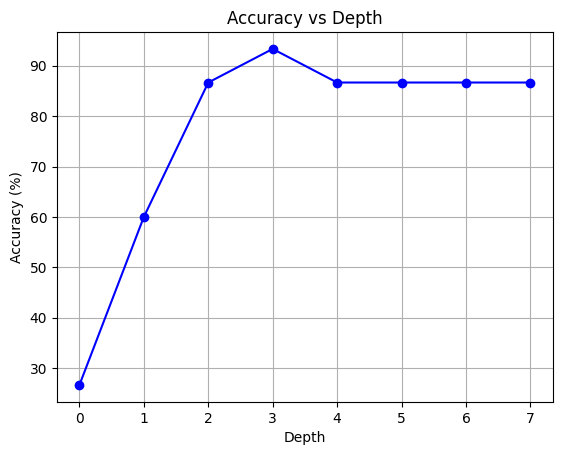

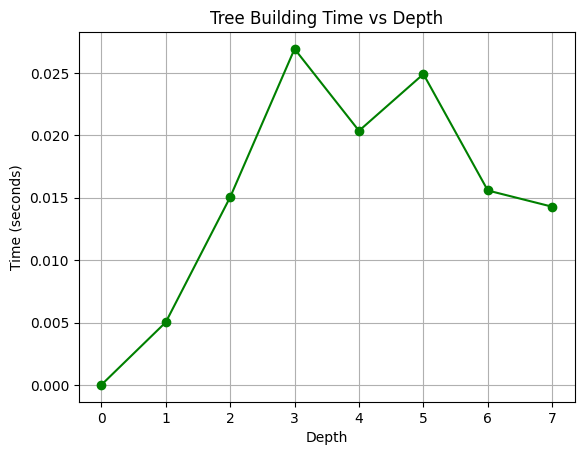

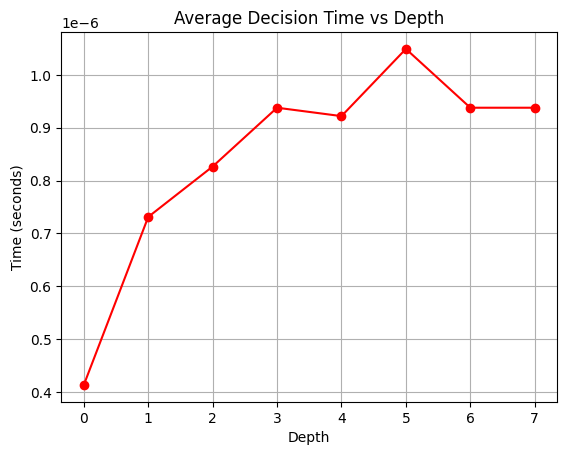

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

depths = [0, 1, 2, 3, 4, 5, 6, 7]
making_tree_times = []
accuracies = []
average_making_decision_times = []

samples_number = len(y_test)

for depth in depths:
    print(20*"-----")
    print(f"Depth: {depth}")
    decision_classifier = DecisionTreeClassifier(depth)
    start_time = time.time()
    decision_classifier.fit(x_train, y_train)
    making_tree_time = time.time() - start_time
    making_tree_times.append(making_tree_time)
    print(f"Making tree time: {making_tree_time}")

    correctly_predicted = 0
    making_decision_time_sum = 0.0
    i = 1
    for sample, gt in zip(x_test, y_test):
        start_time = time.time()
        prediction = decision_classifier.predict(sample)
        making_decision_time_sum += time.time() - start_time
        if prediction == gt:
            correctly_predicted += 1
            print(f"Number {i}/{samples_number}:\t Features: {sample},\t Actual: {gt},\t Predicted: {prediction}")
        else:
            print(f"Number {i}/{samples_number}:\t Features: {sample},\t Actual: {gt},\t Predicted: {prediction}\t Wrong!")
        i += 1

    accuracy = (correctly_predicted / samples_number) * 100
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy}%")
    average_making_decision_time = making_decision_time_sum / samples_number
    average_making_decision_times.append(average_making_decision_time)
    print(f"Average making decision time: {average_making_decision_time}")
    time.sleep(0.1)

plt.plot(depths, accuracies, marker='o', color='blue', label='Accuracy')
plt.title('Accuracy vs Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

plt.plot(depths, making_tree_times, marker='o', color='green', label='Tree Building Time')
plt.title('Tree Building Time vs Depth')
plt.xlabel('Depth')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

plt.plot(depths, average_making_decision_times, marker='o', color='red', label='Average Decision Time')
plt.title('Average Decision Time vs Depth')
plt.xlabel('Depth')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.show()

Jak widać tendencja współczynnika poprawności predykcji jest poprawna w funkcji głębokości - jest on rosnący. Jednakże widać, że dla głębokości od 4 do 7 współczynnik ten jest mniejszy niż dla głębokości 3. Wynika to z faktu, że w tym przypadku liczba danych testowych wynosi jedynie 15, a więc jedno niepoprawne przypisanie skutkuje znacznym spadkiem wartości współczynnika poprawności predykcji. Patrząc na dane powyżej wykresów, można zauważyć, że dla pierwszej próbki wynik jest zawsze błędny, wynika to z tego, że najprawdopodobniej różni się ona znacznie od pozostałych. Być może dla większych głębokości przeszukiwania zaczyna się przeuczenie modelu, stąd pogorszenie poprawności przewidywania.
Na wykresach zależności czasowych widać, że konstruowanie drzewa trwa o kilka rzędów wielkości dłużej niż sama predykcja z wykorzystaniem już gotowego drzewa. Jednak warto zauważyć, że w tym przypadku czas trwania obliczeń nie rośnie aż tak drastycznie w funkcji głębokości drzewa.

## Eksperyment 2
W tym eksperymencie, w odróżnieniu od pozostałych, za każdym razem wykorzystywano inny podział losowy danych na zbiory uczące i testowe, a dodatkowo zmieniano proporcje podziału. Podobnie jak w poprzednim eksperymencie były też zmieniane głębokości przeszukiwania. Jako że wybór danych do odpowiednich zbiorów był losowy, predykcję dla konkretnych parametrów powtarzano 5 razy, za każdym razem losując dane według innej kolejności losowej.


------------------------------------------------------------------------------------------------------------------------
Depth: 0
------------------------------------------------------------

Test/train ratio: 0.1/0.9
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Repetition:1/5:
Accuracy: 25.000%
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Repetition:2/5:
Accuracy: 25.000%
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Repetition:3/5:
Accuracy: 12.500%
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Repetition:4/5:
Accuracy: 12.500%
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Repetition:5/5:
Accuracy: 12.500%

Partial summary of results:
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Average accuracy: 17.500%
------------------------------------------------------------

Test/train ratio: 0.1/0.9
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Repetition:1/5:
Accuracy: 26.667%
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Repetition:2/5:
Accuracy: 20.000%
Depth: 0;	 Test/train ratio: 0.1/0.9;	 Repetition:3/5:
Accuracy: 20.000%
Depth: 0;	 Test/

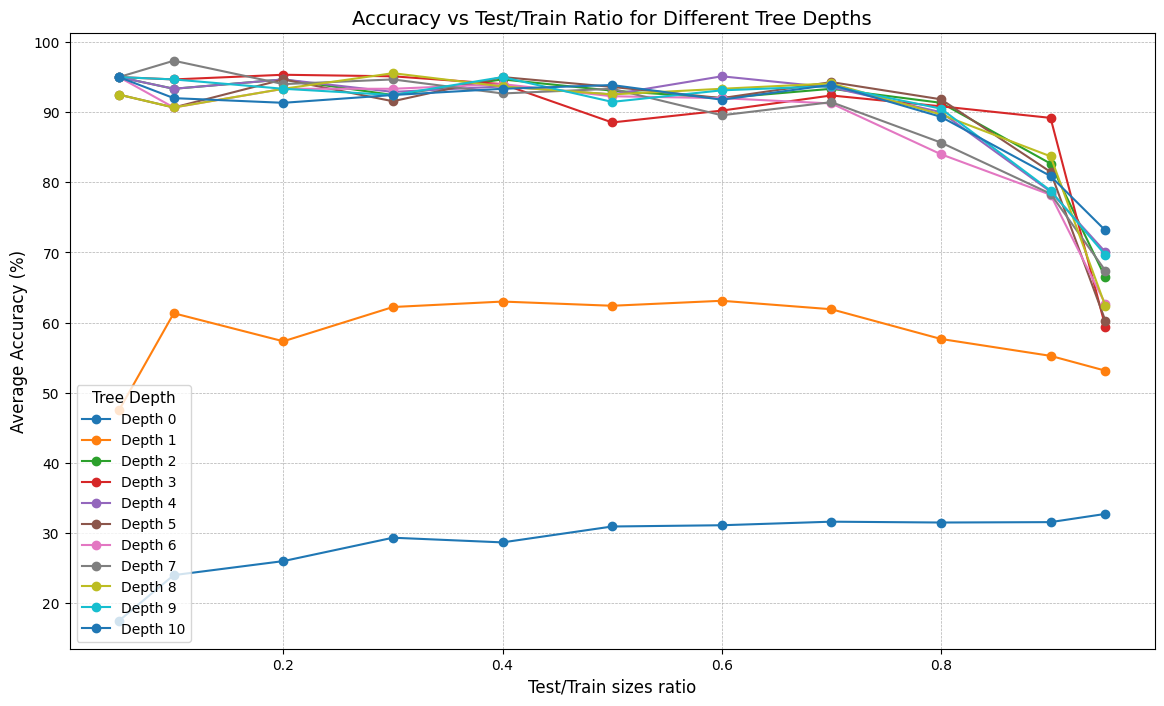

In [11]:
depths = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
repetitions = 5

results = {}

for depth in depths:
    results.setdefault(depth, {})
    print(20*"------")
    print(f"Depth: {depth}")
    for test_size in test_sizes:
        print(10*"------")
        print(f"\nTest/train ratio: {test_size:.1f}/{(1 - test_size):.1f}")
        accuracies = []

        for repetition in range(repetitions):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
            decision_classifier = DecisionTreeClassifier(max_depth=depth)
            decision_classifier.fit(x_train, y_train)

            samples_number = len(y_test)
            correctly_predicted = sum(decision_classifier.predict(sample) == gt for sample, gt in zip(x_test, y_test))

            accuracy = (correctly_predicted / samples_number) * 100
            accuracies.append(accuracy)
            print(f"Depth: {depth};\t Test/train ratio: {test_size:.1f}/{(1 - test_size):.1f};\t Repetition:{repetition + 1}/{repetitions}:")
            print(f"Accuracy: {accuracy:.3f}%")

        avg_accuracy = np.mean(accuracies)
        results[depth][test_size] = avg_accuracy
        print("\nPartial summary of results:")
        print(f"Depth: {depth};\t Test/train ratio: {test_size:.1f}/{(1 - test_size):.1f};\t Average accuracy: {avg_accuracy:.3f}%")
    print("\n\n\n")

plt.figure(figsize=(14, 8))
for depth, test_results in results.items():
    test_sizes_depth = list(test_results.keys())
    avg_accuracies_depth = list(test_results.values())
    plt.plot(test_sizes_depth, avg_accuracies_depth, marker='o', label=f"Depth {depth}")

plt.title("Accuracy vs Test/Train Ratio for Different Tree Depths", fontsize=14)
plt.xlabel("Test/Train sizes ratio", fontsize=12)
plt.ylabel("Average Accuracy (%)", fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend(title="Tree Depth", fontsize=10, title_fontsize=11, loc="lower left")
plt.show()

Jak widać, dla głębokości drzewa wynoszących 0 i 1 poprawność predykcji jest słaba. Znaczący skok tej miary jakości następuje od głębokości równej 2, powyżej której kolejne drzewa decyzyjne nie różnią się za bardzo poprawnością działania. I większy jest współczynnik danych testowych do trenujących, a więc danych trenujących jest mniej, tym mniej są one zróżnicowane, co powoduje powstawanie zjawiska przeuczenia, co skutkuje gorszym działaniem kwalifikatora. Model wtedy dopasowywuje się zbyt mocno do danych uczących, przez źle radzi sobie z innymi danymi. Warto zauważyć, że im większa głębokość drzewa, tym jest ono mniej odporne na przeuczenie. Kolejną rzeczą, na którą trzeba zwrócić uwagę, jest fakt, że w tym eksperymencie za każdym uruchomieniem programu wyniki są delikatnie inne, co wynika z faktu, że dane do uczenia są wybierane losowo.